In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#Use "-1" for CPU-only devices

#If working on GPU enviroment
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#Limit the memory allocated by tensorflow to only the necessary amount

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PYTHONHASHSEED'] = '2'

In [2]:
import numpy as np
from numpy.random import seed
seed(18)

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.random import set_seed
from tensorflow.keras.utils import set_random_seed
set_seed(18)
set_random_seed(18)

import keras

import matplotlib.pyplot as plt

from Supporting_func_file import *

Version_check()

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


All packages are using the targeted versions.


## Preparing the imaging data

#### Loading the data

In [3]:
file_path = "Data_sets/Scan_Dense_connective_tissue/Dense_connective_tissue_data.npz"

flatten_counts, _ = Load_data_file(file_path)
arranged_counts = np.moveaxis(flatten_counts.reshape((299,160,7)),0,1)
#Arranging the flatten data to form a matrix with dimensions corresponding to the measured image

data_shapes = arranged_counts.shape

print("Shape of the arranged count distributions:", data_shapes)

Shape of the arranged count distributions: (160, 299, 7)


#### Pre-processing the data

In [4]:
arranged_counts_normed = Probability_norm(arranged_counts)
#Normalization, sum(count distribution)=1 for each pixel

print("Sum of the normed count distribution (7 detection channels) for the top-left-most pixel =", arranged_counts_normed.sum(axis=-1)[0,0])

Sum of the normed count distribution (7 detection channels) for the top-left-most pixel = 1.0


## Evaluation

In [5]:
#Loading the model
model = load_model("Trained_models/Scan_Dense_connective_tissue_model.h5", 
                   custom_objects={"fidelity_metric": fidelity_metric})

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               2000      
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 batch_normalization (BatchN  (None, 250)              1000      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 250)               62750     
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 250)              1000      
 hNormalization)                                        

In [6]:
predicted_states_rho = Flat_to_Density(model.predict(
                                                    arranged_counts_normed.reshape(data_shapes[0]*data_shapes[1], data_shapes[2])
                                                    )).reshape(data_shapes[0], data_shapes[1], 2,2)
#Predicted polarization states in the form of coherence matrices

predicted_states_bloch = Rho_to_Stokes(predicted_states_rho)
#Predicted polarization states in the form of normalized Stokes parameters, i.e., Bloch parameters

1495/1495 [==============================] - 3s 1ms/step


## Plotting

First, we visualizate each Stokes parameter individually.

Text(0.5, 1.0, 'Third Bloch parameter')

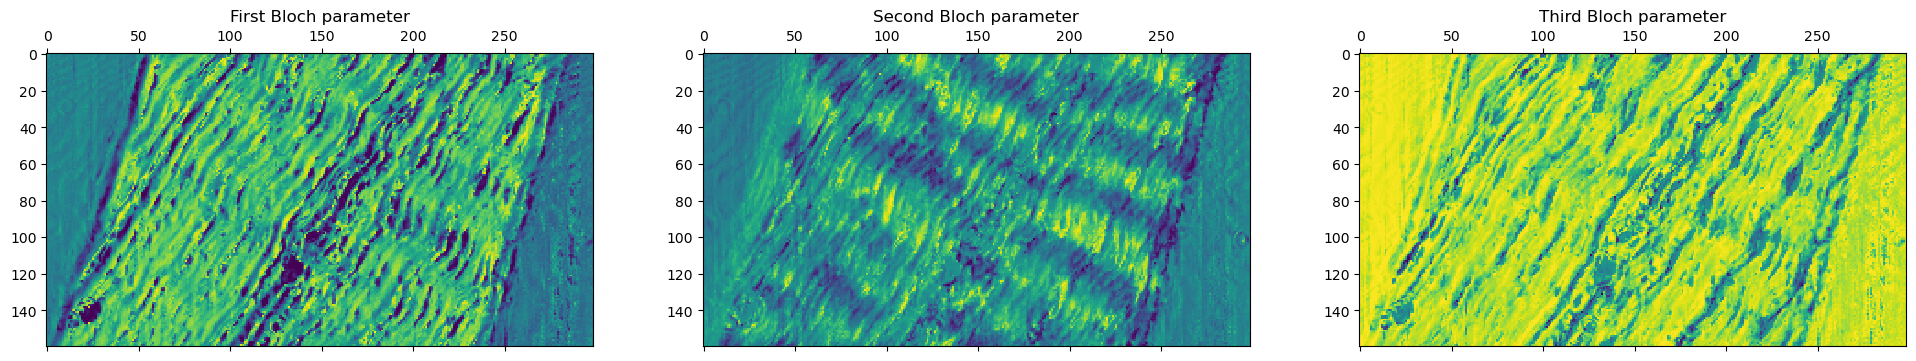

In [7]:
plt.figure(figsize=(24,4))
plt.subplot(131)
plt.matshow(predicted_states_bloch[:,:,0], fignum=False, cmap="viridis")
plt.title("First Bloch parameter")

plt.subplot(132)
plt.matshow(predicted_states_bloch[:,:,1], fignum=False, cmap="viridis")
plt.title("Second Bloch parameter")

plt.subplot(133)
plt.matshow(predicted_states_bloch[:,:,2], fignum=False, cmap="viridis")
plt.title("Third Bloch parameter")

And now, we visualizte the scan using all three Bloch parameters as RGB channels.

Text(0.5, 1.0, 'Scan - RGB image using Bloch parameters')

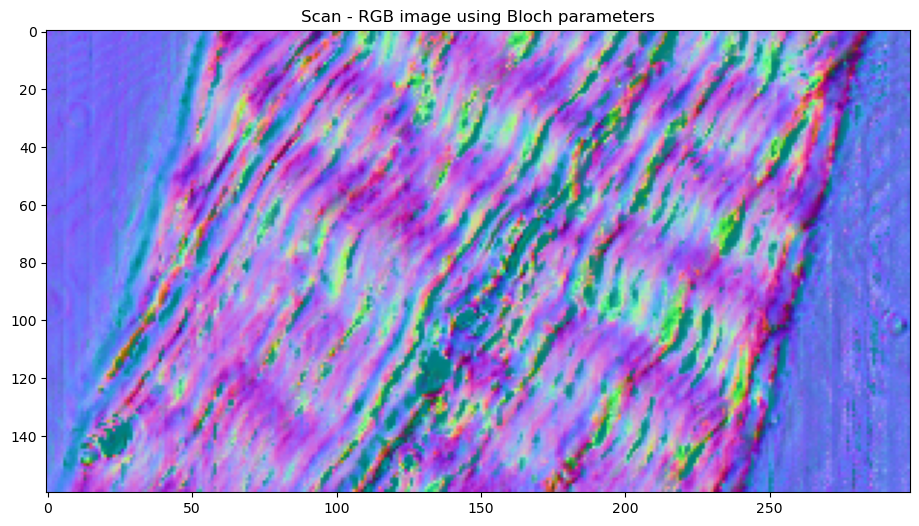

In [8]:
predicted_states_bloch_rescaled = (predicted_states_bloch + 1) / 2
#While plt.matshow accepts the Stokes range <-1,1>, plt.imshow requires the range of values to be <0,1> for color visualization

plt.figure(figsize=(12,6))
plt.imshow(predicted_states_bloch_rescaled)
plt.title("Scan - RGB image using Bloch parameters")

Text(0.5, 1.0, 'Scan - RGB image using Bloch parameters')

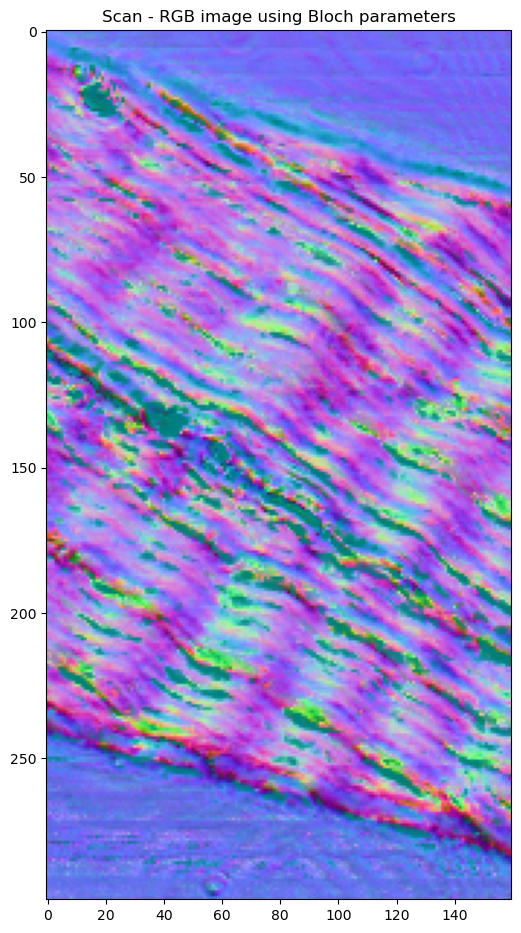

In [9]:
#Flipping the image to the format used in the publication
flipped_image = np.copy(np.flip(np.moveaxis(predicted_states_bloch_rescaled,1,0), axis=1))

plt.figure(figsize=(6,12))
plt.imshow(flipped_image)
plt.title("Scan - RGB image using Bloch parameters")

In [10]:
print("The three chosen points with listed Bloch parameters:")
print("Point A: RGB channels =", flipped_image[75,30], "corresponding to Bloch parameters =", 2*flipped_image[75,30]-1)
print("Point B: RGB channels =", flipped_image[222,45], "corresponding to Bloch parameters =", 2*flipped_image[222,45]-1)
print("Point C: RGB channels =", flipped_image[20,140], "corresponding to Bloch parameters =", 2*flipped_image[20,140]-1)

The three chosen points with listed Bloch parameters:
Point A: RGB channels = [0.66799153 0.28463689 0.91469243] corresponding to Bloch parameters = [ 0.33598305 -0.43072622  0.82938486]
Point B: RGB channels = [0.04930393 0.52300133 0.53237451] corresponding to Bloch parameters = [-0.90139214  0.04600267  0.06474901]
Point C: RGB channels = [0.47866486 0.40838661 0.98866807] corresponding to Bloch parameters = [-0.04267028 -0.18322679  0.97733614]
